In [1]:
# indir = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_simpleUnion/donors/donor1/dendro_bc/knn_kparam_30"
# outdir = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_simpleUnion_knn_resolution_30/clonalShift_method_dendro_bc/clones_ranked"
# #only used if clone is mt, to remove some clones. see where we save the csv and text file
# is_mt = False
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_simpleUnion_knn_resolution_30/clonalShift_method_dendro_bc/cells_meta.tsv"
# condition = "noInput"

indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor1/dendro_bc/knn_kparam_30"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_dendro_bc/clones_ranked"
cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_dendro_bc/cells_meta.tsv"
is_mt = False
condition = "inputOnly"


p_thresh = 0.1 
clone_id = "cloneID" # "den_clust"



In [2]:
if condition != "inputOnly" and condition != "noInput":
    raise ValueError("condition needs to be inputOnly or noInput")
suffix = "cultured" if condition == "noInput" else "input"

In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
%load_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

from scipy.stats import rankdata, gmean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fig_utils from mplh


## Load ncells and save to output. Sort by ncells

In [5]:
ncells_df = pd.read_csv(join(indir, f"{condition}_ncells.csv"),  index_col=0)
ncells_df = ncells_df.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]

ncells_df.columns = [f"{x}_{suffix}" for x in ncells_df.columns]


#ncells_df = pd.merge(input_ncells,ncells_df,left_index=True, right_index=True, suffixes=["_input", "_cultured"])
ncells_df = ncells_df.loc[ncells_df.sum(axis=1).sort_values()[::-1].index]
ncells_df

,count_input
cloneID,
1_C1,2284
1_C0,66


## Load shuffle hypergeometric results for input and cultured
## Convert into long df with cloneID ('index'), clusterID ('variable'), pval, method (hypergeo or one of four shuffle methods), and condition ('input' or 'cultured')

In [6]:
hyper = pd.read_csv(join(indir, "hypergeo_pvals.csv"),  index_col=0)
shuffle_df = pd.read_csv(join(indir, "shuffle_results_pvals.csv"), index_col=0)
shuffle_df = shuffle_df.rename({"value":"pval"}, axis=1)
shuffle_df["condition"] = suffix

hyper_df = hyper.reset_index().melt(id_vars="index", value_name="pval")
hyper_df["method"] = "hypergeo"
hyper_df["condition"] = suffix


#noInput_df = pd.concat((noInput_hyper_df, noInput_shuffle_df), axis=0, ignore_index=True)
#df = pd.concat((input_df, noInput_df), axis=0).reset_index(drop=True)
df = pd.concat((hyper_df, shuffle_df), axis=0, ignore_index=True)

df["variable"] = df["variable"].astype(object).astype(str)


df

,index,variable,pval,method,condition
0,1_C0,0,0.640000,hypergeo,input
1,1_C1,0,0.992636,hypergeo,input
2,1_C0,1,0.357359,hypergeo,input
3,1_C1,1,0.992636,hypergeo,input
4,1_C0,2,0.992636,hypergeo,input
...,...,...,...,...,...
95,1_C1,7,1.000000,clone_min,input
96,1_C0,8,1.000000,clone_min,input
97,1_C1,8,1.000000,clone_min,input
98,1_C0,9,1.000000,clone_min,input


In [7]:
df["method"].unique()

array(['hypergeo', 'global_all', 'global_min', 'clone_all', 'clone_min'],
      dtype=object)

## Create 'sig score' that merges the hypergeo and the shuffle results. Score 0-4, with 4 the highest

In [8]:
p_df = df.copy()
p_df["is_sig"] = p_df["pval"]<p_thresh
p_df

def check_sig(x):
    #print(x.head())
    name, clust, cond = x.name
    x = x.set_index("method")["is_sig"]
    assert(x.index.duplicated().sum()==0)
    sig = 0    
    if 'hypergeo' not in x.index:
        return sig
    if x["hypergeo"]==True:
        if ("global_all" in x) and x["global_all"]==True:
            if ("clone_min" in x) and (x["clone_min"]==True):
                if ("global_min" in x) and (x["global_min"]==True):
                    sig = 4    
                else:
                    sig = 3
            else:
                sig = 2
        else:
            sig = 1
    return sig

p_df = p_df.groupby(["index","variable", "condition"]).apply(check_sig)
p_df


# df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")

# df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")

p_df_out = p_df.reset_index().rename({0:"significant_score"}, axis=1)
#p_df_out.set_index( )
p_df_out["cluster_condition"] = p_df_out.apply(lambda x: f'{x["variable"]}_{x["condition"]}', axis=1)


#p_df_out["clone_condition"] = p_df_out.apply(lambda x: f'{x["index"]}_{x["condition"]}', axis=1)

p_df_out = p_df_out.pivot(index='index', columns='cluster_condition', values="significant_score").fillna(0)

p_df_out

cluster_condition,0_input,1_input,2_input,3_input,4_input,5_input,6_input,7_input,8_input,9_input
index,,,,,,,,,,
1_C0,0,0,0,0,0,0,0,1,0,0
1_C1,0,0,1,0,0,0,0,0,0,0


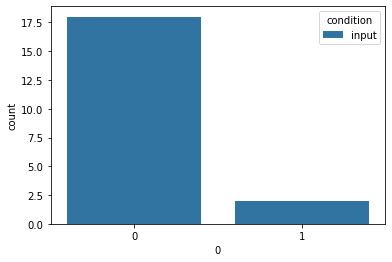

In [9]:
sns.countplot(data=p_df.reset_index(), x=0, hue="condition")
plt.savefig(join(outdir, "hypergeo_sig_score_distribution.pdf"))


## Save heatmap for initial hypergeo 

In [10]:
clone_meta = pd.DataFrame(index=p_df_out.columns, columns = ["condition"])
clone_meta["condition"] = suffix
clone_meta

,condition
cluster_condition,
0_input,input
1_input,input
2_input,input
3_input,input
4_input,input
5_input,input
6_input,input
7_input,input
8_input,input


## Get the minimum of each clone shift. This will be used for rankigng later

In [11]:
min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index()
min_df

min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide
ncells_df["ncells"] = ncells_df.sum(axis=1)
min_df_wide = pd.concat((min_df_wide,ncells_df), axis=1)


In [12]:
min_df_wide

,clone_all_input,clone_min_input,global_all_input,global_min_input,hypergeo_input,count_input,ncells
1_C0,1.0,1.0,1.0,1.0,0.051475,66,66
1_C1,1.0,1.0,1.0,1.0,0.054345,2284,2284


# *Get the clone order based on the ncells 


In [13]:

if is_mt:
    print("removing donor specific variants")
    print(min_df_wide.shape)
    clone_order_keep = []
    cells_meta = pd.read_csv(cells_meta_f, sep="\t", index_col=0)
    kept_clones = []
    kept_clones_cells = []
    
    for x in cells_meta.columns:
        if "cloneID_" in x:
            kept_clones_cells.append(x)
            kept_clones.append(x.replace("cloneID_", ""))
    
    min_df_wide = min_df_wide.loc[min_df_wide.index.isin(kept_clones)]
    print("after removal")
    print(min_df_wide.shape)
        

In [14]:
rank_df = pd.merge(min_df_wide.drop("ncells", axis=1).apply(lambda x: rankdata(x, method='max'), axis=0),
                   min_df_wide[["ncells"]].apply(lambda x: rankdata(x, method='min'), axis=0), 
                   left_index=True, right_index=True)
#rank_df = min_df_wide.apply(lambda x: rankdata(x, method='max'), axis=0)
# gmean_ser = rank_df.apply(gmean, axis=1)
# gmean_ser = gmean_ser.sort_values()
rank_df = rank_df.sort_values("ncells")[::-1]
rank_df


## Get the clone order based on the mean of the rankings
clone_order = rank_df.index
min_df_wide = min_df_wide.loc[clone_order]
rank_df = rank_df.loc[clone_order]

min_clone_meta = pd.DataFrame(index=min_df_wide.columns, columns = ["condition"])
min_clone_meta["condition"] = suffix
rank_df

,clone_all_input,clone_min_input,global_all_input,global_min_input,hypergeo_input,count_input,ncells
1_C1,2,2,2,2,2,2,2
1_C0,2,2,2,2,1,1,1


## Plot rankings ordered by clone, annd save output

## Save:
a) cloneID_rank.png  
b) cloneID_order.txt - line-delimited text file with cloneID on each line  
c) cloneID_rank.csv  - csv file of the ranking for each category  
d) all_pvals: all p-values for for each clone-method-cluster-condition

In [15]:
clone_order

Index(['1_C1', '1_C0'], dtype='object')

In [16]:
with open(join(outdir, "cloneID_rank_ncells.txt"), 'w') as f:
    f.write('\n'.join(clone_order))

In [17]:
rank_df.to_csv(join(outdir, "cloneID_rank_ncells_df.csv"))

## Plot the rankings

In [18]:
rank_df

,clone_all_input,clone_min_input,global_all_input,global_min_input,hypergeo_input,count_input,ncells
1_C1,2,2,2,2,2,2,2
1_C0,2,2,2,2,1,1,1


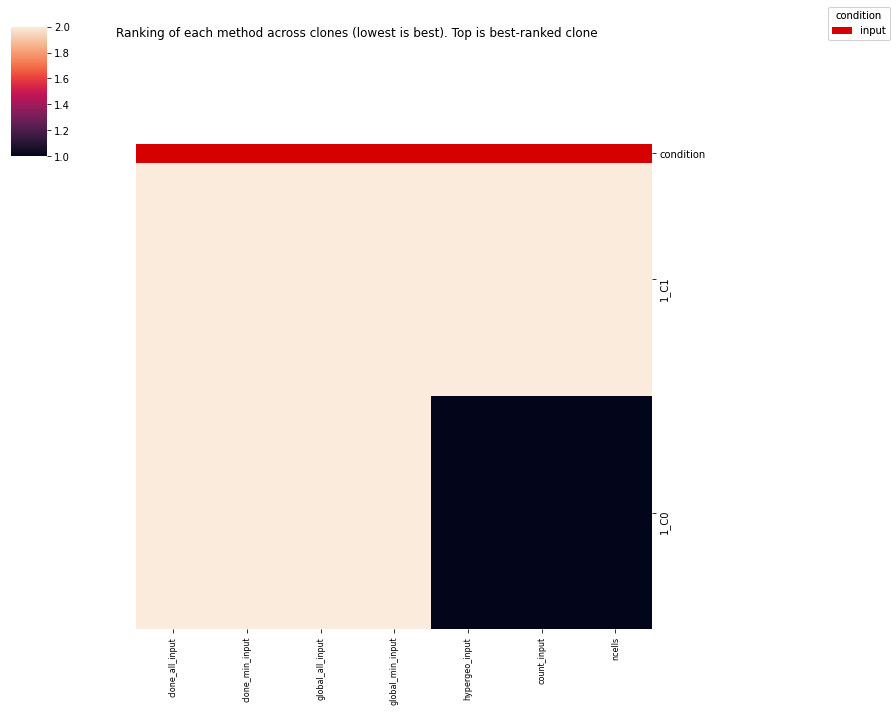

In [19]:
g = ch.plot_cluster(rank_df, to_row_clust=False, to_col_clust=False, col_meta=min_clone_meta[["condition"]])
g.fig.suptitle("Ranking of each method across clones (lowest is best). Top is best-ranked clone")
plt.savefig(join(outdir, "cloneID_rank_sizes.png"))

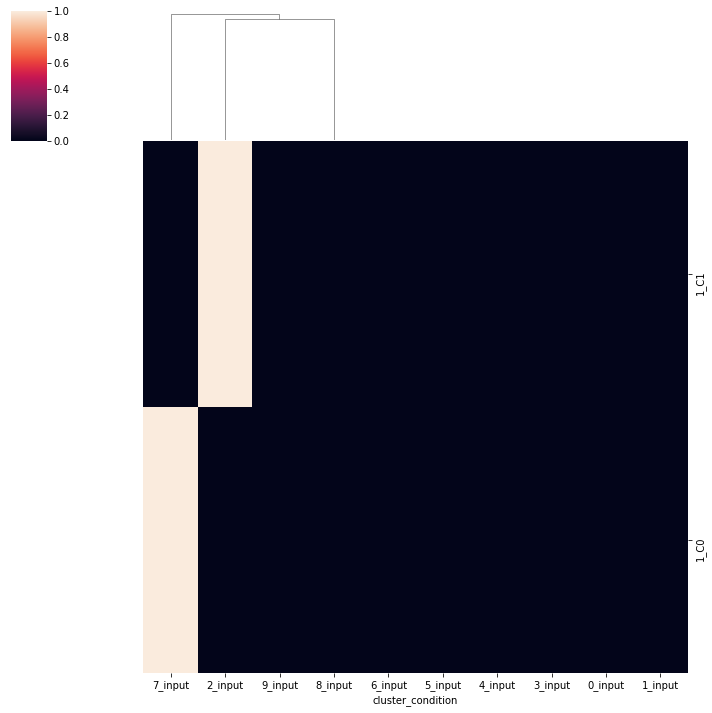

In [20]:
g = sns.clustermap(p_df_out.loc[clone_order], row_cluster=False)
plt.savefig(join(outdir, f"{suffix}_sigScore_cloneOrder.pdf"))

## Convert p-vals into * or shapes (a. hypergeo sig. b. hyper+global all c. hyper+global all + clone min d. hyper+global all + clone min + global min